In [1]:
import os
from abc import ABC, abstractmethod
from collections import defaultdict
from pprint import pprint, pformat
from itertools import combinations
from collections import deque

from graph import Graph
import networkx as nx
import pandas
import matplotlib.pyplot as plt

pandas.options.display.max_colwidth = 0

from kf_lib_data_ingest.common.io import (
    read_df
)
from kf_lib_data_ingest.common.concept_schema import (
    CONCEPT,
    DELIMITER,
    concept_from,
    concept_attr_from
)
from kf_lib_data_ingest.common.pandas_utils import merge_wo_duplicates

SOURCE_DATA_DIR = os.path.abspath('data')
TEST_DATA_DIR = os.path.join(SOURCE_DATA_DIR, 'test')
EXTRACT_DATA_DIR = os.path.join('./output/ExtractStage/')

In [8]:
def display_dfs(df_dict):
    for key, df in df_dict.items():
        print(f'Dataframe {key}')
        display(df)
        
def load_data(input_dir, enable_display=False):
    out_dfs = {}
    for fn in os.listdir(input_dir):
        fp = os.path.join(input_dir, fn)
        ext = os.path.splitext(fn)[-1]
        if (os.path.isfile(fp) and (not fn.startswith('.')) and (ext not in {'.zip', '.json'})):
            out_dfs[fn] = read_df(os.path.join(input_dir, fn))
    if enable_display:
        print(f'Loading {fn} into df')
        display_dfs(out_dfs)

    return out_dfs

print('\nExtracted data files ....')
# Read in extracted data files into dict
extract_data_dfs = load_data(EXTRACT_DATA_DIR)

# Test dataframes
print('\nTest data files ....')
test_data_dfs = load_data(TEST_DATA_DIR, enable_display=False)

# Dev dataframes
df_dict = {
    'fp.csv': pandas.DataFrame(
        {
            CONCEPT.FAMILY.ID: ['F1', 'F2', 'F2'],
            CONCEPT.PARTICIPANT.ID: ['P1', 'P1' ,'P2']
        }
    ),
    'fpb.csv': pandas.DataFrame(
        {
            CONCEPT.FAMILY.ID: ['F1', None],
            CONCEPT.PARTICIPANT.ID: ['P3', 'P4'],
            CONCEPT.BIOSPECIMEN.ID: ['B3', 'B3'],
        }
    ),
    'fb.csv': pandas.DataFrame(
        {
            CONCEPT.FAMILY.ID: ['F1', 'F1', 'F1'],
            CONCEPT.BIOSPECIMEN.ID: ['B1', 'B1', 'B3']
        }
    ),
     'pg.csv': pandas.DataFrame(
        {
            CONCEPT.PARTICIPANT.ID: ['P1'],
            CONCEPT.GENOMIC_FILE.URL_LIST: ['G1']
        }
    )
}


Extracted data files ....

Test data files ....


Building graph from 6 files

Running PARTICIPANT|ID-->FAMILY|ID test on 6 files ...
Running test using explicit connections first
✅ PARTICIPANT|ID|P10 is linked to {'FAMILY|ID|F10'}
❌ PARTICIPANT|ID|P11 is linked to set()
✅ PARTICIPANT|ID|P13 is linked to {'FAMILY|ID|F13'}
✅ PARTICIPANT|ID|P5 is linked to {'FAMILY|ID|F2'}
✅ PARTICIPANT|ID|P6 is linked to {'FAMILY|ID|F3'}
✅ PARTICIPANT|ID|P2 is linked to {'FAMILY|ID|F1'}
✅ PARTICIPANT|ID|P1 is linked to {'FAMILY|ID|F1'}
✅ PARTICIPANT|ID|P3 is linked to {'FAMILY|ID|F1'}
✅ PARTICIPANT|ID|P4 is linked to {'FAMILY|ID|F2'}
✅ PARTICIPANT|ID|P9 is linked to {'FAMILY|ID|F9'}
Running test using implied connections
❌ PARTICIPANT|ID|P11 is linked to set()

Running FAMILY|ID-->PARTICIPANT|ID test on 6 files ...
Running test using explicit connections first
✅ FAMILY|ID|F10 is linked to {'PARTICIPANT|ID|P10'}
❌ FAMILY|ID|F12 is linked to set()
✅ FAMILY|ID|F13 is linked to {'PARTICIPANT|ID|P13'}
✅ FAMILY|ID|F2 is linked to {'PARTICIPANT|ID|P5', 'PARTI

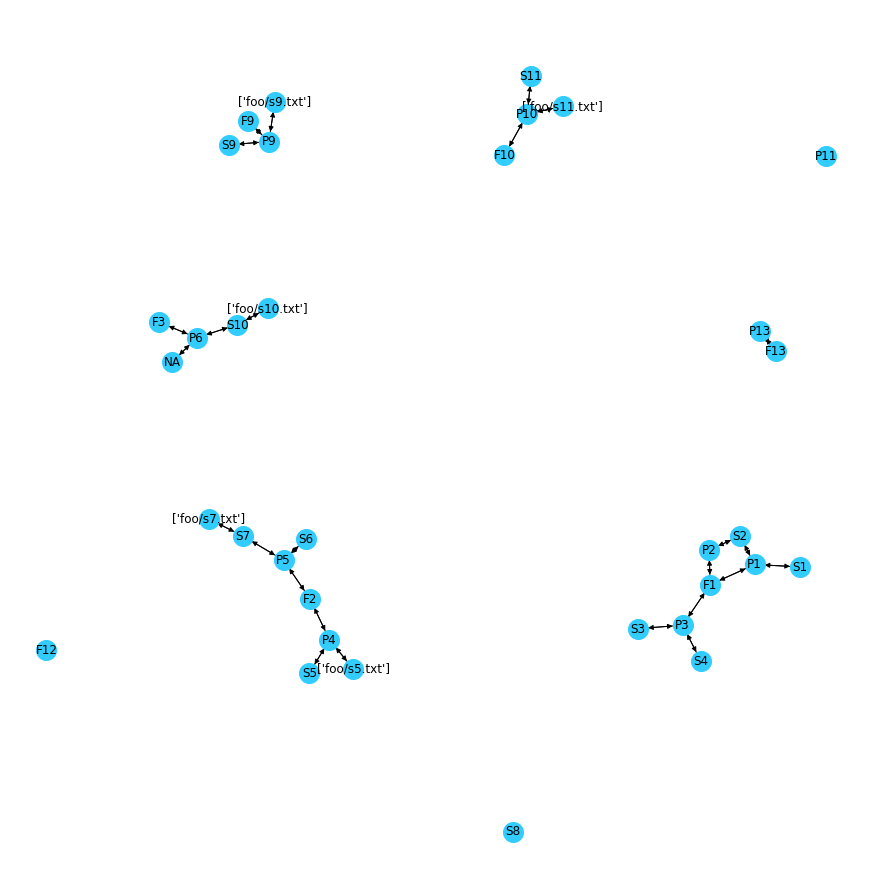


Generated validation report at /Users/singhn4/Projects/kids_first/kf-ingest-packages/kf_ingest_packages/packages/SD_46SK55A3/validation_report.md


,result,name,description,details,error_locations,test_type
0,✅,Expected Participant Unique Count = 10,The number of uniquely identifiable participants found in study must be equal to the expected count,None,NaN,count-test
0,✅,Expected Specimen Unique Count = 12,The number of uniquely identifiable specimens found in study must be equal to the expected count,None,NaN,count-test
0,❌,A Participant must have exactly 1 gender,"Every uniquely identifiable Participant must have exactly 1 gender from the acceptable list: Male, Female",0 Participant have linked PARTICIPANT|GENDER,None,attribute-test
0,❌,A Participant is in at least 1 Family Group,Every uniquely identifiable Participant must be linked to at least 1 uniquely identifiable Family within the study,Participant P11 is linked to 0 Family entities,Found P11 in files: pf.csv,relationship-test
0,❌,A Family Group must have at least 1 Participant,Every uniquely identifiable Family Group must have at least 1 uniquely identifiable Participant within the study,Family F12 is linked to 0 Participant entities,Found F12 in files: pf.csv,relationship-test
0,❌,A Specimen comes from 1 Participant,Every uniquely identifiable Specimen must be linked to exactly 1 uniquely identifiable Participant within the study,"Biospecimen S2 is linked to 2 Participant entities: {'P1', 'P2'}\nBiospecimen S8 is linked to 0 Participant entities","Found S2 in files: spf.csv,sfp2.csv\nFound S8 in files: spf.csv",relationship-test
0,❌,A Participant must have at least 1 Specimen,Every uniquely identifiable Participant must have at least 1 uniquely identifiable Specimen within the study,Participant P11 is linked to 0 Biospecimen entities\nParticipant P13 is linked to 0 Biospecimen entities,Found P11 in files: pf.csv\nFound P13 in files: pf.csv,relationship-test
0,❌,A Sequence Manifest File Record represents only 1 Specimen,Every uniquely identifiable Sequence Manifest File Record must be linked to exactly 1 uniquely identifiable Specimen within the study,"Genomic_File ['foo/s5.txt'] is linked to 3 Biospecimen entities: {'S7', 'S5', 'S6'}",Found ['foo/s5.txt'] in files: pg.csv,relationship-test
0,❌,A Specimen must have at least 1 Sequence Manifest File Record,Every uniquely identifiable specimen must be linked to at least 1 uniquely identifiable Sequence Manifest File Record within the study,Biospecimen S2 is linked to 0 Genomic_File entities\nBiospecimen S1 is linked to 0 Genomic_File entities\nBiospecimen S3 is linked to 0 Genomic_File entities\nBiospecimen S4 is linked to 0 Genomic_File entities\nBiospecimen S8 is linked to 0 Genomic_File entities,"Found S2 in files: spf.csv,sfp2.csv\nFound S1 in files: spf.csv\nFound S3 in files: spf.csv\nFound S4 in files: spf.csv\nFound S8 in files: spf.csv",relationship-test


In [59]:
type_relations = {
    CONCEPT.FAMILY.ID: {
        CONCEPT.PARTICIPANT.ID
    },
    CONCEPT.PARTICIPANT.ID: {CONCEPT.BIOSPECIMEN.ID},
    CONCEPT.BIOSPECIMEN.ID: {CONCEPT.GENOMIC_FILE.URL_LIST},
    CONCEPT.GENOMIC_FILE.URL_LIST: {}
}

def validate_count(count, min_count, max_count):
    if count < min_count:
        return False
    if (max_count is not None) and (count > max_count):
        return False
    return True

def concept_from(key_or_id):
    try:
        c = ''.join(key_or_id.split(DELIMITER)[0])
    except:
        c = None
    return c

def concept_attr_from(key_or_id):
    try:
        c = DELIMITER.join(key_or_id.split(DELIMITER)[0:2])
    except:
        c = None
    return c

class ExtendedDiGraph(nx.DiGraph):
    """
    Extends graph_theory.Graph with some more functions
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def has_edge(self, left, right, bidirect=True):
        return (
            super().has_edge(left, right) or
            super().has_edge(right, left)
        )
    
    def add_edge(self, left, right, bidirect=True, allow_redundant_path=True): 
        path_exists = False
        # Only add edge if path doesn't already exist between left, right        
        if not allow_redundant_path:
            try:
                path_exists = nx.has_path(self, left, right)
            except nx.NodeNotFound:
                pass
        
        if not path_exists:    
            super().add_edge(left, right)
            if bidirect:
                super().add_edge(right, left)
        
    def parents(self, node_id):
        return [edge[0] for edge in self.in_edges(node_id)]
    
    def children(self, node_id):
        return [edge[-1] for edge in self.out_edges(node_id)]
    
    def debug_view(self):
        return {
            nid.split(DELIMITER)[-1]: {n.split(DELIMITER)[-1] for n in neighbors}
            for nid, neighbors in nx.to_dict_of_dicts(self).items()
        }
    
    def draw(self, output_dir=None, **kwargs):
        g = nx.DiGraph(self.debug_view())
        pos = nx.spring_layout(g)
        plt.figure(1,figsize=(12,12)) 
        kwargs.update(
            {
                'font-weight': 'bold',
                'with_labels': True,
                'node_color': '#33ccff',
                'node_size': 400
            },
        )
        nx.draw(g, **kwargs)
 
        output_path = None
        if output_dir:
            output_path = os.path.join(output_dir, 'graph.svg')
            plt.savefig(output_path, format='SVG')
        
        plt.show()
        
        return output_path
        
class TypeGraph(object):
    def __init__(self, relations):
        self.adj_list = relations
        self.graph = self._build()
    
    def _build(self):
        graph = ExtendedDiGraph()
        for node, neighbors in self.adj_list.items():
            for n in neighbors:
                graph.add_edge(node, n)
        return graph
    
    def __repr__(self):
        return pformat(nx.to_dict_of_dicts(self.graph))
    
class Node(object):
    def __init__(self, key, value, filepaths=None):
        self.id = f'{key}{DELIMITER}{value}'
        self.key = key
        self.value = value
        self.filepaths = filepaths
        self.concept = concept_from(key)
        self.attribute = concept_attr_from(key)
    
    def __repr__(self):
        return self.id
    
class NodeIndex(object):
    def __init__(self):
        self.nodes = defaultdict(dict)
        
    def add_node(self, node):
        self.nodes[node.concept][node.id] = node
    
    def get_node(self, node_id):
        concept = concept_from(node_id)
        return self.nodes.get(concept, {}).get(node_id)

class DataGraph(object):
    
    def __init__(self, df_dict, type_relations):
        self.df_dict = df_dict
        self.node_index = NodeIndex()
        self.type_graph = TypeGraph(type_relations)
        self.build(df_dict)
    
    def build(self, df_dict):
        self.graph = ExtendedDiGraph()
        # Build graph of unambiguous connections first
        process_later_dfs = {}
        print(f'Building graph from {len(df_dict.keys())} files')
        for filepath, df in df_dict.items():
            process_later = set()
            for left, right in combinations(df.columns, 2):
                unambiguous_conn = (
                    self.type_graph.graph.has_edge(left, right, bidirect=True) 
                )
                if unambiguous_conn:
                    self.insert_df(filepath, df[[left, right]])
                else:
                    process_later.update([left, right])
            
            df_later = df[list(process_later)]
            if not df_later.empty:
                process_later_dfs[filepath] = df_later
            
        # Add ambiguous connections into the graph        
        for filepath, df in process_later_dfs.items():
            for left, right in combinations(df.columns, 2):
                self.insert_df(filepath, df[[left, right]], allow_redundant_path=False)
                    
    def insert_df(self, filepath, df, allow_redundant_path=True):
        for left, right in combinations(df.columns, 2):
            for i, row in df.iterrows():
                # Add left and right nodes of edge
                nodes = []
                for n in [left, right]:
                    if row[n] and pandas.notnull(row[n]):
                        node = Node(n, row[n], filepaths=set([filepath]))
                        self.add_node(node)
                        nodes.append(node)
                # Add edges
                if len(nodes) > 1: # prevents edges with a node = Null
                    self.graph.add_edge(
                        nodes[0].id, nodes[1].id, 
                        bidirect=True, 
                        allow_redundant_path=allow_redundant_path
                    )          
                    
    def add_node(self, node):
        if node.id in self.graph:
            filepaths = node.filepaths
            node = self.get_node(node.id)
            node.filepaths.update(filepaths)

        self.graph.add_node(node.id)
        self.node_index.add_node(node)
    
    def get_node(self, node_id):
        return self.node_index.get_node(node_id)
        
    def nodes_by_type(self, node_id):
        concept = concept_from(node_id)
        return self.node_index.nodes.get(concept, {})    
    
    def connected_nodes(self, node_id, concept_attr):
        # -- Search the graph of node_id for nodes of same type --
        ret_nodes = set()
        visited = set([node_id])
        queue = deque([node_id])

        # BFS
        while queue:
            current = queue.popleft()

            # Found a node with target concept, add to output
            if concept_attr and (concept_attr_from(current) == concept_attr):
                ret_nodes.add(current)

            # Not found - keep searching neighbors
            for neighbor in nx.neighbors(self.graph, current):
                # Add neighbor to list if it has not been searched yet
                if neighbor not in visited:
                    queue.append(neighbor)
                    visited.add(neighbor)

        return ret_nodes

def result_to_emoji(result):
    result = int(result)
    emap = {
        0: '❌',
        1: '✅',
        2: '☑️'
    }
    return emap[result]

class ValidationTest(ABC):
    def __init__(self, name, description, test_type, test_params, id=None):
        self.id = id
        self.name = name
        self.description = description
        self.test_type = test_type
        self.test_params = test_params
    
    def run(self, df_dict, *args, **kwargs):
        print(f'\nRunning {self.id} test on {len(df_dict.values())} files ...')
        return self._run(df_dict, *args, **kwargs)
        
    def build_report(self, *args, **kwargs):
        required_columns = set(['name', 'description', 'result', 'details'])

        df = self._build_report(*args, **kwargs)
        if not isinstance(df, pandas.DataFrame):
            raise Exception(
                f'{type(self).__name__}._build_report must return '
                f'a pandas.DataFrame object!'
            )

        if not (required_columns.issubset(set(df.columns))):
            raise Exception(
                f'{type(self).__name__}._build_report DataFrame must have all required '
                f'columns: {required_columns}'
            )

        return df
    
    @abstractmethod
    def _run(self, df_dict):
        raise NotImplementedError()

    
    @abstractmethod
    def _build_report(self, *args, **kwargs):
        raise NotImplementedError()

    def to_dict(self):
        return {
            'test_id': self.id,
            'type': self.test_type,
            'name': self.name,
            'description': self.description,
            'input_params': self.test_params
        }

    def to_dataframe(self):
        return pandas.DataFrame([self.to_dict()])

    def __repr__(self):
        return pformat(self.to_dict())

class ValidationTestResult(ABC):
    def __init__(
        self, validation_test, result, data=None, message=None, result_details=None, error_locations=None
    ):
        self.id = None
        self.validation_test = validation_test
        self.result = result
        self.data = data
        self.message = message or (
            f"{result_to_emoji(int(result))} "
            f"{self.validation_test.test_type.title()} "
            f"for '{self.validation_test.name}' "
            f"{'Succeeded!' if result else 'Failed!'}"
        )
        self.result_details = result_details
        self.error_locations = error_locations
    
    def to_dict(self):
        d = self.validation_test.to_dict()
        d.update({
            'result': self.result,
            'data': self.data,
            'message': self.message,
            'details': self.result_details,
            'error_locations': self.error_locations
        })
        return d
    
    def to_dataframe(self):
        d = self.to_dict()
        df = pandas.DataFrame([d])
        return df.drop('data', axis=1)
      
    def __repr__(self):
        return pformat(self.to_dict())
        
class CountValidationTest(ValidationTest):
    def __init__(self, name, description, concept_name, min_count, max_count, data_graph):
        super().__init__(
            name,
            description,
            id=f'{concept_name}-UNIQUE-COUNT', 
            test_type='count-test',
            test_params=(concept_name, min_count, max_count)
        )
        self.concept_name = concept_name
        self.min_count = min_count
        self.max_count = max_count
        self.test_result = None
        self.data_graph = data_graph
    
    def to_dict(self):
        d = super().to_dict()
        d.update(
            {
                'concept': self.concept_name,
                'min_count': self.min_count,
                'max_count': self.max_count
            }
        )
        return d
    
    def _run(self, df_dict):
        
        # Unique count test
        error = None
        nodes = self.data_graph.nodes_by_type(concept_from(self.concept_name))
        uc = len({n for n in nodes if n.startswith(self.concept_name)})
        result = validate_count(uc, self.min_count, self.max_count)
        # Count check failed
        if not result:
            error = (self.concept_name, uc)     
        self.test_result = ValidationTestResult(self, result, None, result_details=error)

        return self.test_result
        

    def _build_report(self):
        test_df = self.test_result.to_dataframe()
        report_df = test_df[['result', 'name', 'description', 'details']]
        report_df['result'] = test_df['result'].apply(
            lambda x: result_to_emoji(x)
        )
        report_df['details'] = test_df['details'].apply(
            lambda x: f'Found {x[1]} {x[0]} in data' if x else None
        )
        return report_df

class RelationshipValidationTest(ValidationTest):
    """
    Validate relationships between enitity instances

    For example given:
    
        self.node_left=SPECIMEN.ID
        self.node_right=PARTICIPANT.ID
        self.min_relations=1
        self.max_relations =1

    A SPECIMEN must be linked to at least 1 PARTICIPANT and no more than 1 PARTICIPANT
    Find the SPECIMENS that violate this rule
    """  
    def __init__(
        self, name, description, node_left, node_right, min_relations, max_relations, data_graph, 
        include_implied_conns=True
    ):
        super().__init__(
            name,
            description,
            id=f'{node_left}-->{node_right}', 
            test_type='relationship-test',
            test_params=(node_left, node_right, min_relations, max_relations)
        )
        self.node_left = node_left
        self.node_right = node_right
        self.min_relations = min_relations
        self.max_relations = max_relations
        self.data_graph = data_graph
        self.include_implied_conns=include_implied_conns
        self.test_result = None
    
    def to_dict(self):
        d = super().to_dict()
        d.update(
            {'relation': (self.node_left, self.node_right)}
        )
        return d
    
    def _run(self, df_dict):
        print('Running test using explicit connections first')
        success = False
        all_errors = {}
        direct_conn_errors = {}
        indirect_conn_errors = {}
        for node in self.data_graph.nodes_by_type(self.node_left):
            neighbors = {
                n for n in self.data_graph.graph.neighbors(node)
                if concept_from(n) == concept_from(self.node_right)
            }
            success = validate_count(len(neighbors), self.min_relations, self.max_relations)
            if not success:
                if len(neighbors) == 0:
                    indirect_conn_errors[node] = neighbors
                else:
                    direct_conn_errors[node] = neighbors
            print(f'{result_to_emoji(success)} {node} is linked to {neighbors}')

        if self.include_implied_conns:
            print('Running test using implied connections')
            nodes = [
                node for node, errors in indirect_conn_errors.items()
                if not errors
            ]
            for node in nodes:
                indirect_conn_nodes = self.data_graph.connected_nodes(
                    node, self.node_right
                )
                # Found valid connection through indirect links         
                success = validate_count(
                    len(indirect_conn_nodes), self.min_relations, self.max_relations
                )
                print(f'{result_to_emoji(success)} {node} is linked to {indirect_conn_nodes}')
                if success:
                    indirect_conn_errors.pop(node)
                else:                
                    # Node is still invalid due to indirect links
                    indirect_conn_errors[node] = indirect_conn_nodes
        
        # Collect file locations of errors
        all_errors.update(direct_conn_errors)
        all_errors.update(indirect_conn_errors)
        file_locs_of_errors = {
            error_node: self.data_graph.get_node(error_node).filepaths
            for error_node in all_errors
        }
        
        # Create test result        
        self.test_result = ValidationTestResult(
            self, 
            len(all_errors) < 1, 
            result_details=all_errors,
            error_locations=file_locs_of_errors
        )
        return self.test_result
    
    def _build_report(self):
        def format_errors(row, left, right):
            error_dict = row['details']
            success = row['result']
            if (not success and 
                (len(error_dict) == len(self.data_graph.nodes_by_type(self.node_left)) and
                all([(len(errors) == 0) for errors in error_dict.values()]))
               ):
                return f'0 {concept_from(left).title()} have linked {right}'

            msgs = []
            for node_id, errors in error_dict.items():
                n = self.data_graph.get_node(node_id)
                concept_right = concept_from(right).title()
                if len(errors) > 1:
                    e_ids = {self.data_graph.get_node(e_id).value
                         for e_id in errors}
                    error_str = f'{len(e_ids)} {concept_right} entities: {e_ids}'
                else:
                    error_str = f'0 {concept_right} entities'
                    
                msgs.append(f'{concept_from(node_id).title()} {n.value} '
                            f'is linked to {error_str}')
            return '\n'.join(msgs)
                    
        def format_error_locs(loc_dict, left):
            if len(self.data_graph.nodes_by_type(left)) == len(loc_dict):
                return None
            
            msgs = []
            for node_id, locations in loc_dict.items():
                n = self.data_graph.get_node(node_id)
                msgs.append(f"Found {n.value} in files: {','.join(locations)}")
            return '\n'.join(msgs)
            
        test_df = self.test_result.to_dataframe()
        report_df = test_df[['result', 'name', 'description', 'details', 'error_locations']]
        report_df['result'] = test_df['result'].apply(lambda x: result_to_emoji(x))
        report_df['details'] = test_df.apply(
            lambda row: format_errors(row, self.node_left, self.node_right), axis=1
        )
        report_df['error_locations'] = test_df['error_locations'].apply(
            lambda x: format_error_locs(x, self.node_left)
        )
        
        return report_df

def markdown_report(df, output_dir, graph_img_path=None):
    filepath = os.path.join(output_dir, 'validation_report.md')
    
    # Prepare data 
    out_cols = ['result', 'name', 'details', 'error_locations']
    counts = (
        df[df['test_type'] == 'count-test'][out_cols]
        .drop(['error_locations'],axis=1)
    )
    relations = df[df['test_type'] == 'relationship-test'][out_cols]
    attributes = df[df['test_type'] == 'attribute-test'][out_cols]
    definitions = df[['test_type', 'name', 'description']]
    
    # Write markdown     
    output = []
    output.append('# 📓 Data Validation Report')
    if graph_img_path:
        output.append(f'### \* View data in a connected [graph]({graph_img_path})')
    output.append('## Count Tests')
    output.append(counts.to_markdown(index=False))
    output.append('\n## Relation Tests')
    output.append(relations.to_markdown(index=False))
    output.append('\n## Attribute Tests')
    output.append(attributes.to_markdown(index=False))
    output.append('\n## Test Definitions')
    output.append(definitions.to_markdown(index=False))
    
    with open(filepath, 'w') as md_file:
        md_file.write('\n'.join(output))
    
    print(f'\nGenerated validation report at {filepath}')

def run_tests(df_dict, test_params, type_relations):
    report_dfs = []
    
    # Build data graph
    g = DataGraph(df_dict, type_relations)
    
    # Run tests
    for test_type, tests in test_params.items():
        if test_type == 'count-test':
            cls = CountValidationTest
            extra_params = (g,)
        else:
            cls = RelationshipValidationTest
            extra_params = (g,)
            
        for test in tests:
            test_obj = cls(
                test['name'], test['desc'], *test['params'], 
                *extra_params, **test.get('kwargs', {})
            )
            test_df = test_obj.run(df_dict).to_dataframe()
            report_df = test_obj.build_report()            
            report_df['test_type'] = test_type
            report_dfs.append(report_df)
    
    # Collect test report dfs     
    report_df = pandas.concat(report_dfs)
    report_df = report_df.sort_values(by=['result', 'test_type'])

    # Draw graph    
    p = g.graph.draw(output_dir=os.getcwd())

    # Create markdown report
    markdown_report(report_df, output_dir=os.getcwd(), graph_img_path=p)

    return report_df

test_params = {
    'relationship-test': [
        {
            'name': 'A Participant is in at least 1 Family Group',
            'desc': 'Every uniquely identifiable Participant must be linked to at '
                    ' least 1 uniquely identifiable Family within the study',
            'params': (CONCEPT.PARTICIPANT.ID, CONCEPT.FAMILY.ID, 1, None)
        },
        {
            'name': 'A Family Group must have at least 1 Participant',
            'desc': 'Every uniquely identifiable Family Group must have '
                    'at least 1 uniquely identifiable Participant within the study',
            'params': (CONCEPT.FAMILY.ID, CONCEPT.PARTICIPANT.ID, 1, None)
        },
        {
            'name': 'A Specimen comes from 1 Participant',
            'desc': 'Every uniquely identifiable Specimen must be linked to '
                    ' exactly 1 uniquely identifiable Participant within the study',
            'params': (CONCEPT.BIOSPECIMEN.ID, CONCEPT.PARTICIPANT.ID, 1, 1)
        },
        {
            'name': 'A Participant must have at least 1 Specimen',
            'desc': 'Every uniquely identifiable Participant must have at least 1 '
                    ' uniquely identifiable Specimen within the study',
            'params': (CONCEPT.PARTICIPANT.ID, CONCEPT.BIOSPECIMEN.ID, 1, None)
        },
        {
            'name': 'A Sequence Manifest File Record represents only 1 Specimen',
            'desc': 'Every uniquely identifiable Sequence Manifest File Record must be linked to '
                    'exactly 1 uniquely identifiable Specimen within the study',
            'params': (CONCEPT.GENOMIC_FILE.URL_LIST, CONCEPT.BIOSPECIMEN.ID, 1, 1),
        },
        {
            'name': 'A Specimen must have at least 1 Sequence Manifest File Record',
            'desc': 'Every uniquely identifiable specimen must be linked to '
                    'at least 1 uniquely identifiable Sequence Manifest File Record '
                    'within the study',
            'params': (CONCEPT.BIOSPECIMEN.ID, CONCEPT.GENOMIC_FILE.URL_LIST, 1, None)
        }
    ],
    'attribute-test': [
        {
            'name': 'A Participant must have exactly 1 gender',
            'desc': 'Every uniquely identifiable Participant must have exactly 1'
                    ' gender from the acceptable list: Male, Female',
            'params': (CONCEPT.PARTICIPANT.ID, CONCEPT.PARTICIPANT.GENDER, 1, 1)
        }
    ],
    'count-test': [
        {
            'name': 'Expected Participant Unique Count = 10',
            'desc': 'The number of uniquely identifiable participants found in '
                    'study must be equal to the expected count',
            'params': (CONCEPT.PARTICIPANT.ID, 10, 10)
        },
        {
            'name': 'Expected Specimen Unique Count = 12',
            'desc': 'The number of uniquely identifiable specimens found in '
                    'study must be equal to the expected count',
            'params': (CONCEPT.BIOSPECIMEN.ID, 12, 12)
        }
    ]
}
report_df = run_tests(test_data_dfs, test_params, type_relations)
display(report_df)